# Project: Creating a Kaggle Workflow

## Goal
Create a data science workflow

# Context
Data science, and particularly machine learning, contain many dimensions of complexity when compared with standard software development. In standard software development, code not working as you expect can be caused by a number of factors along two dimensions:

* Bugs in implementation
* Algorithm design

Machine learning problems, have many more dimensions:

* Bugs in implementation
* Algorithm design
* Model issues
* Data quality
The result of this is that there are exponentially more places that machine learning can go wrong ( (see the excellent post [Why is machine learning 'hard'?](http://ai.stanford.edu/~zayd/why-is-machine-learning-hard.html)).

By defining a workflow for yourself, you can give yourself a framework with which to make iterating on ideas quicker and easier, allowing yourself to work more efficiently.

Then, here we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train=pd.read_csv("train.csv")
holdout=pd.read_csv("test.csv")

holdout.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

## Preprocessing the Data

Note:
One of the many benefits of using Jupyter is that (by default) it uses the [IPython kernel](http://ipython.readthedocs.io/en/stable/) to run code. This gives you all the benefits of IPython, including code completion and 'magic' commands. (to read more about the internals of Jupyter and how it can help to work more efficiently, check out this [blog post Jupyter Notebook Tips, Tricks and Shortcuts.](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/))

We can use one of those magic commands, the %load command, to load an external file. The %load command will copy the contents of the file into the current notebook cell. The syntax is simple:

%load [filename]

Import the file, functions.py which contains some usefull functions which will save us building those functions from scratch.

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
def process_df(df):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    for c in ['Age_categories', 'Fare_categories','Title', 'Cabin_type', 'Sex']:
        df=create_dummies(df,c)
        
    return df

In [5]:
train = process_df(train)
holdout = process_df(holdout)

## Exploring the Data
The Kaggle workflow we are going to build will combine these different processes:

* Data exploration, to find patterns in the data
* Feature engineering, to create new features from those patterns or through pure experimentation
* Feature selection, to select the best subset of our current set of features
* Model selection/tuning, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then Submit to Kaggle to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

In [6]:
explore_cols=['SibSp', 'Parch', 'Survived']
explore_df=train[explore_cols].copy()

#Inspecting the type of the columns
explore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


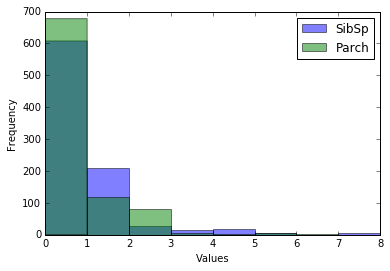

In [7]:
# view the distribution of values in the columns
explore_df.drop('Survived', axis=1).plot.hist(alpha=0.5,bins=8)
plt.xlabel("Values")
plt.show()

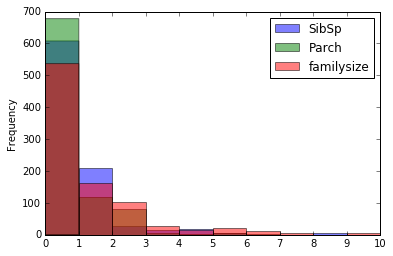

In [8]:
#combine the columns and look at the resulting distribution
explore_df["familysize"] = explore_df[["SibSp","Parch"]].sum(axis=1)
explore_df.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

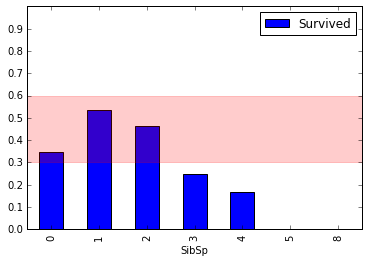

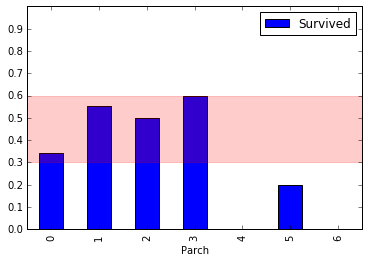

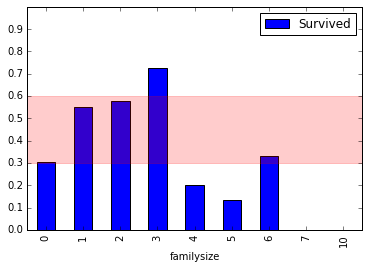

In [9]:
# look at the survival rate for different values of the columns
for col in explore_df.columns.drop('Survived'):
    pivot=explore_df.pivot_table(index=col,values='Survived')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that by combining the values of SibSp and Parch into a single column, only 30% of the passengers who had no family members onboard survived.

## Engineering New Features

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

* 1 if the passenger has zero family members onboard
* 0 if the passenger has one or more family members onboard

In [10]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"]= df['familysize'].apply(lambda x: 0 if x>0 else 1)
    df = df.drop("familysize",axis=1)
    return df

"""
#Using df.loc
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df
"""

'\n#Using df.loc\ndef process_isalone(df):\n    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)\n    df["isalone"] = 0\n    df.loc[(df["familysize"] == 0),"isalone"] = 1\n    df = df.drop("familysize",axis=1)\n    return df\n'

In [11]:
train=process_isalone(train)
holdout =process_isalone(holdout)

In [12]:
train[["SibSp","Parch","isalone"]].head()

SibSp  Parch  isalone
0      1      0        0
1      1      0        0
2      0      0        1
3      1      0        0
4      0      0        1

## Selecting the Best-Performing Features
The next step in our workflow is feature selection. we will use scikit-learn's feature_selection.RFECV class to automate selecting the best-performing features using recursive feature elimination.

To speed up our Kaggle workflow, we can create a function that performs this step for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

The first parameter when you instantiate a RFECV() object is an estimator. At the time we used a Logistic Regression estimator, but we've since discovered that Random Forests seems to be a better algorithm for this Kaggle competition.

Let's write a function that:

* Accepts a dataframe as input
* Performs data preparation for machine learning
* Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [14]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

In [15]:
cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms
Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

* The name of the particular model
* An estimator object for the model
* A dictionary of hyperparameters that we'll use for grid search.

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's [model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained GridSearchCV objects as well as the results so we can see which was the most accurate.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
def select_model(df, features):
    
    all_X = df[features]
    all_y = df["Survived"]
    
    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]
    
    for model in models:
        print(model['name'])
        print('*********************************')
        
        grid=GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X,all_y)
        
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [18]:
result = select_model(train,cols)

LogisticRegression
*********************************
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
*********************************
Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
*********************************
Best Score: 0.8294051627384961
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 4, 'max_depth': 5}



## Making a Submission to Kaggle
After running your function, we will have three scores from three different models. At this point in the workflow we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

if we find that adding a feature to our model doesn't improve our accuracy, we should go back to data exploration and repeat the cycle again.

Let's create a function to automate the submission to Kaggle

In [19]:
def save_submission_file(model,cols, filename="submission"):
    
    holdout_predictions=model.predict(holdout[cols])
    
    holdout_ids=holdout["PassengerId"]
    
    submission_df={
        "PassengerId":holdout_ids,
        "Survived":holdout_predictions
    }
    
    submission=pd.DataFrame(submission_df)
    
    submission.to_csv(filename)    

In [20]:
# Retrieve the best performing model obtained earlier
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)

## Next Steps
Here are some suggestions of next steps:

* Continue to explore the data and create new features, following the workflow and using the functions we created.
* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use some different algorithms in the select_model() function, like [support vector machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) or [perceptron](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) linear models.
* Experiment with [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of GridSearchCV to speed up your select_features() function.